# GloVe-BiLSTM


## Imports and fixed SEED

In [ ]:
import torch
import numpy as np
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Only necessary for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Set definition

Here we define the Dataset Structure and load the training and test dataset as TabularDataset.

The columns PhraseId and SentenceId are artifacts of the raw Dataset-structure and can be omitted for training and testing.

In [ ]:
# Create Field objects
# use Spacy tokenizer
# specify English language
# need lenghts for padded sequences
PHRASE = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
SENTIMENT = data.LabelField()

# Create tuples representing the columns
fields = [
  (None, None), # ignore PhraseId column
  (None, None), # ignore SentenceId column
  ('Phrase', PHRASE),
  ('Sentiment', SENTIMENT)
]

# Load the dataset in tsv format
train_ds, test_ds = data.TabularDataset.splits(
   path = './data',
   train = 'train.tsv',
   test = 'test_mapped.tsv',
   format = 'tsv',
   fields = fields,
   skip_header = True
)

# Check an example
print(vars(train_ds[0]))

{'Phrase': ['A', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], 'Sentiment': '1'}


## Train and Validation Split

Here we split the Data into Training and Validation-Set. We used the common split of 70/30 as it represents a good amount of training data, while at the same time having a rather large validation-set. This gives meaningful results in terms of generalization of the validation score.

Another important setting is the usage of stratification based on the sentiment labels. This ensures an equal distribution of the labels in the training and validation set.

In [ ]:
import random

# Create validation dataset; splits 70/30 by default
train_ds, valid_ds = train_ds.split(split_ratio=0.7, 
                                    stratified=True, 
                                    strata_field='Sentiment', 
                                    random_state = random.seed(SEED))

print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 109241
Number of validation examples: 46819
Number of testing examples: 65327


## Creation of vocabulary

Create key for every unique Phrase- or Sentiment-Token and assign to unique value.

Then create word embedding for every token in the Phrase vocabulary.

Note: The vocabulary DataField "SENTIMENT" is not created from the training data to ensure the correct indexing "{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}", and instead a vector of key value pairs is provided.

In [ ]:
# Build vocabulary (using Glove pre-trained word embeddings, dimensionality = 100)
# unknown words in our vocabulary are initialized via a Gaussian distribution
PHRASE.build_vocab(train_ds,
                    vectors = "glove.6B.100d", 
                    unk_init = torch.Tensor.normal_
                    )
# embedding methods: #"glove.6B.100d";"glove.6B.50d";"glove.6B.200d";"glove.6B.300d";"fasttext.en.300d"

sentiment_labels = np.array(['0', '1', '2', '3', '4'])

#SENTIMENT.build_vocab(train_ds) # old version
SENTIMENT.build_vocab(sentiment_labels) # Custom indexing is necessary for correct mapping; {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

print(f"Unique tokens in PHRASE vocabulary: {len(PHRASE.vocab)}")
print(f"Unique tokens in SENTIMENT vocabulary: {len(SENTIMENT.vocab)}")
print(f"Number of tokens, vector dimension: {PHRASE.vocab.vectors.shape}")

Unique tokens in PHRASE vocabulary: 17080
Unique tokens in SENTIMENT vocabulary: 5
Number of tokens, vector dimension: torch.Size([17080, 100])


## Creation of the Iterators

The Iterators are used to yield one batch of the data at a time.

It is noteworthy that the batch size is a parameter that can be tuned.

In [ ]:
BATCH_SIZE = 64 #32, 64, 128, 256, 512

# Creating the iterators
# need sorting within batch for padded sequences
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort = False,
    sort_key = lambda x: len(x.Phrase),
    sort_within_batch = True,
    device = device)

## Model Definition


In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        #Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        #LSTM layer
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        #Fully-Connected Linear Layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #Dropout functionality for reqularizotion
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack embedding sequence to process only the non-padded elements of our sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence; no used in our case
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

Here the weight initialization function is defined, which could be used to replace the default weight initialization.

For tuning, we attempt to initialize the weights of the LSTM layers differently, while fixing the weight initialization of linear layers to Xavier Normal.

In [ ]:
# Define weight initialization function for each layer
def weights_init(layer):
    print(type(layer))
    if type(layer) == nn.Linear: # initialize weights of the linear layers 
        nn.init.xavier_normal_(layer.weight)
    elif type(layer) == nn.LSTM: # initialize weights of the LSTM layers
        for name, param in layer.named_parameters():
            if 'weight' in name:
              nn.init.xavier_normal_(param)
              # Other weight initialization methods:
              #nn.init.xavier_uniform_(param)
              #nn.init.orthogonal_(param)
              #torch.nn.init.ones_(param)
              #torch.nn.init.zeros_(param)

## Parameter and Model Initialization



In [ ]:
INPUT_DIM = len(PHRASE.vocab)
EMBEDDING_DIM = 100                         #50, 100, 200, 300 -> equal to the pre-trained vectors' dimension
HIDDEN_DIM = 256                            #128, 256, 512
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2                                #2, 4, 8
BIDIRECTIONAL = True                        #True, False
DROPOUT = 0.25                              #0.25, 0.5, 0.75
PAD_IDX = PHRASE.vocab.stoi[PHRASE.pad_token]

# model initialization
model = LSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
#model.apply(weights_init)

In [ ]:

def count_parameters(model):
# tells us how many trainable parameters our model has 
# so we can compare the number of parameters across different models

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,020,709 trainable parameters


Copy pre-trained word embeddings into the embedding layer

In [ ]:
pretrained_embeddings = PHRASE.vocab.vectors

# check the size of the pre-trained embeddings;  [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([17080, 100])


In [ ]:
# replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3552,  0.4732,  0.8660,  ...,  0.2483, -0.0049,  0.8731],
        [-0.1431,  0.0487,  0.0565,  ..., -0.0402, -0.3744,  0.5650],
        [-0.3860,  0.3999,  0.2512,  ..., -0.0450, -0.2409,  0.6169]])

In [ ]:
UNK_IDX = PHRASE.vocab.stoi[PHRASE.unk_token]

#  initialize <unk> and <pad> tokens to all zeros
#  they are irrelevant for calculating the sentiment
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3552,  0.4732,  0.8660,  ...,  0.2483, -0.0049,  0.8731],
        [-0.1431,  0.0487,  0.0565,  ..., -0.0402, -0.3744,  0.5650],
        [-0.3860,  0.3999,  0.2512,  ..., -0.0450, -0.2409,  0.6169]])


## Optimizer

- Adaptive Momentum (Adam) Optimizer with included Momentum Term and Gradient Normalization. 
- Regularization Term (weight decay) with small parameter lambda is additionally applied.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), weight_decay = 0.00001)

#weight_decay=0.001,0.0001,0.00001
#optim.SGD(model.parameters(),lr=0.001), optim.Adam, optim.RMSprop 

## Loss Function and Accuracy Method

For a multi-class classification task we use the CrossEntropy Loss and categorical accuracy as our performance metrics.

In [ ]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    #Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Training Method and Evaluation Method

The train method gets called in every epoch and iterates through the dataset in batches. (forward pass, loss calculation, backpropagation, weight update)

The evaluate method calculates the performance of the model on the validation set using the accuracy metric.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.Phrase
        
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, batch.Sentiment)
        
        acc = categorical_accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.Phrase
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
            
            acc = categorical_accuracy(predictions, batch.Sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Training and Evaluation

 Auxiliary function to calculate the duration of the training time for one epoch.

In [ ]:
import time
def epoch_time(start_time, end_time):
    # calculate the duration of the training time for one epoch
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Here the final training loop is executed N times. N is therefore the amount of Training-Epochs. Calls training and evaluation method in every epoch and saves the model with the highest evaluation accuracy.

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []
# to track the average training accuracy per epoch as the model trains
avg_train_acc = []
# to track the average validation accuracy per epoch as the model trains
avg_valid_acc = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_LSTM.pt')

    # calculate average loss over an epoch
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    avg_train_acc.append(train_acc)
    avg_valid_acc.append(valid_acc)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 43s
	Train Loss: 0.977 | Train Acc: 60.08%
	 Val. Loss: 0.860 |  Val. Acc: 64.66%
Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.815 | Train Acc: 66.22%
	 Val. Loss: 0.804 |  Val. Acc: 67.03%
Epoch: 03 | Epoch Time: 0m 43s
	Train Loss: 0.742 | Train Acc: 69.15%
	 Val. Loss: 0.794 |  Val. Acc: 67.36%
Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.690 | Train Acc: 71.47%
	 Val. Loss: 0.795 |  Val. Acc: 67.73%
Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 0.646 | Train Acc: 73.05%
	 Val. Loss: 0.808 |  Val. Acc: 67.84%
Epoch: 06 | Epoch Time: 0m 43s
	Train Loss: 0.609 | Train Acc: 74.52%
	 Val. Loss: 0.845 |  Val. Acc: 66.68%
Epoch: 07 | Epoch Time: 0m 43s
	Train Loss: 0.580 | Train Acc: 75.61%
	 Val. Loss: 0.885 |  Val. Acc: 67.02%
Epoch: 08 | Epoch Time: 0m 43s
	Train Loss: 0.549 | Train Acc: 76.72%
	 Val. Loss: 0.910 |  Val. Acc: 66.31%
Epoch: 09 | Epoch Time: 0m 43s
	Train Loss: 0.523 | Train Acc: 78.01%
	 Val. Loss: 0.960 |  Val. Acc: 65.82%
Epoch: 10 | Epoch T

# Visualization

Loss Visualization

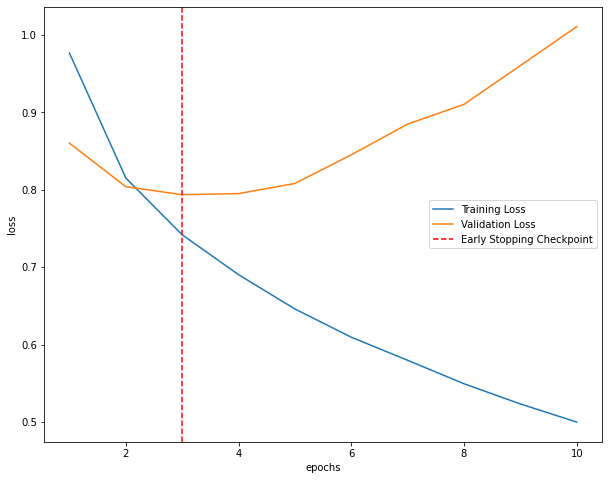

In [ ]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')

#plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Accuracy Visualization

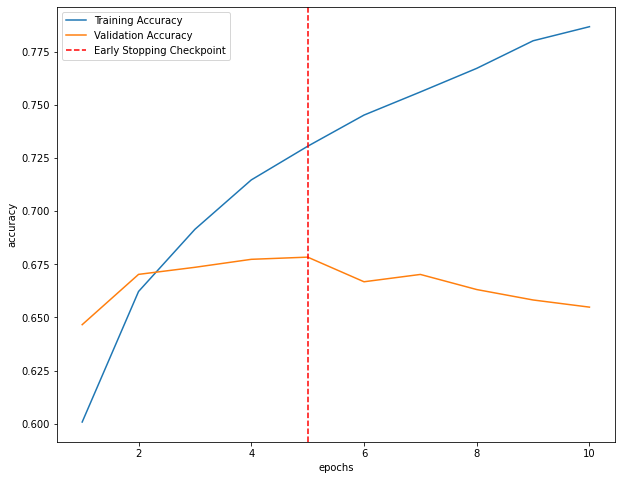

In [ ]:
# Visualize the accuracy as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_acc)+1),avg_train_acc, label='Training Accuracy')
plt.plot(range(1,len(avg_valid_acc)+1),avg_valid_acc,label='Validation Accuracy')

# find position of highest validation accuracy
minposs = avg_valid_acc.index(max(avg_valid_acc))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('accuracy')

#plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.show()
fig.savefig('acc_plot.png', bbox_inches='tight')